<h1> Training <code>color theory</code> </h1>

**Labels:**
* monochrome
* complementary
* analagous

We only want to do transfer learning i.e. create a new head and train that alone, because we need the body to remain the same across different categories aka. MobileNetV2 pretrained on ImageNet

In [1]:
# Dynamically load package
%load_ext autoreload
%autoreload 2

# Display multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from CinemaNet.convert import *
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger
from CinemaNet.blend import *
from CinemaNet.wandb import *
from CinemaNet.custom_head import *
from CinemaNet.train_utils import to_film_ar # other utils will be redefined for clarity

import wandb

In [3]:
model_name = 'cat_color-theory_MNetV2-224x224_tfr-lrn'

In [4]:
wandb.init(name    = f"{re.sub('cat_[a-z].*_MN', 'MN', model_name)}",
           project = 'color_theory',
           entity  = 'synopsis',
           reinit  = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/synopsis/color_theory/runs/2x4dwlvt

In [5]:
%env WANDB_NOTEBOOK_NAME='cat_color-theory.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_color-theory.ipynb'


## Creating Train + Val Datasets

In [6]:
path = Path('/home/rahul/datasets/Synopsis_Model_All_Concepts/color_theory/')

In [7]:
label_dirs = [f for f in os.listdir(path) if f.startswith('color_theory_')]
label_dirs.sort()
label_dirs

['color_theory_analagous',
 'color_theory_complementary',
 'color_theory_monochrome']

In [8]:
for f in label_dirs:
    print(f"{f} --> {len((path/f).ls())}")

color_theory_analagous --> 698
color_theory_complementary --> 632
color_theory_monochrome --> 488


In [9]:
train_fnames = {}
valid_fnames = {}

for label in label_dirs:
    files    = get_files(path/label, presort=True)
    np.random.seed(42)
    np.random.shuffle(files)
    if len(files) < 500:
        valid_fnames[label] = files[:50]
        train_fnames[label] = files[50:]
    else:
        valid_fnames[label] = files[:100]
        train_fnames[label] = files[100:]

In [10]:
fnames_train = sum(train_fnames.values(),[])
fnames_valid = sum(valid_fnames.values(),[])

print(f"# train images: {len(fnames_train)}")
print(f"# valid images: {len(fnames_valid)}")
print(f"# total images: {len(fnames_train) + len(fnames_valid)}")

# train images: 1565
# valid images: 250
# total images: 1815


In [11]:
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))
lls

LabelLists;

Train: ImageList (1565 items)
Image (3, 255, 696),Image (3, 360, 853),Image (3, 738, 960),Image (3, 900, 561),Image (3, 528, 1280)
Path: .;

Valid: ImageList (250 items)
Image (3, 360, 853),Image (3, 553, 1024),Image (3, 437, 650),Image (3, 360, 853),Image (3, 305, 500)
Path: .;

Test: None

In [12]:
img_size   = (224,224)
batch_size = 64

In [13]:
tfms = get_transforms()
tfms = tfms[0], []      # remove cropping tfm from validation-transforms

In [14]:
data = (lls
        .label_from_folder()
        .transform(tfms=get_transforms(),
                   size=img_size,
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (1565 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous
Path: .;

Valid: LabelList (250 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous
Path: .;

Test: None

In [15]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
color_theory_analagous      597
color_theory_complementary  531
color_theory_monochrome     437

In [16]:
vc = pd.value_counts(data.valid_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
color_theory_analagous      100
color_theory_complementary  100
color_theory_monochrome      50

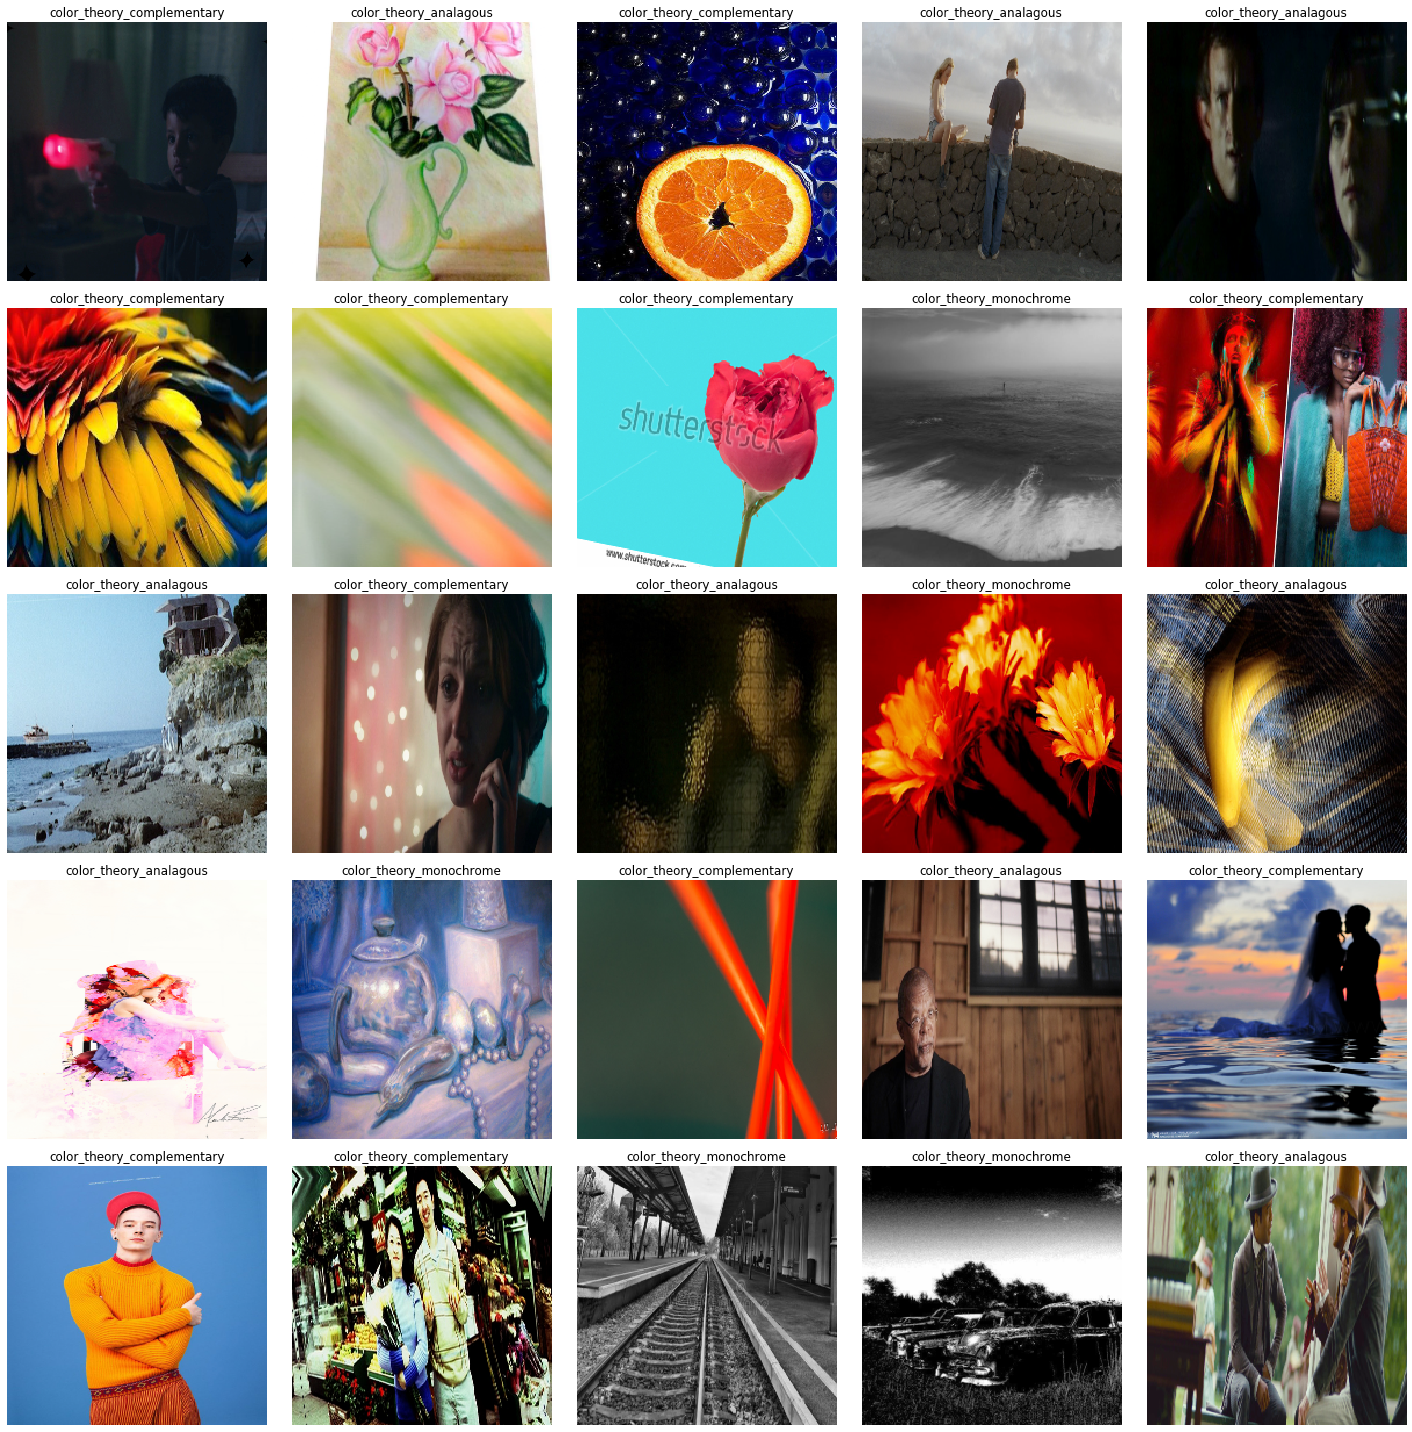

In [24]:
data.show_batch()

## Model Setup

### Architecture, Loss Function, Optimiser

In [17]:
arch = models.mobilenet_v2
loss_func = LabelSmoothingCrossEntropy()
opt_func  = Ranger

In [18]:
model_name

'cat_color-theory_MNetV2-224x224_tfr-lrn'

In [19]:
metrics = [accuracy, FBeta()]

def get_callbacks(learner, mod_name, monitor='f_beta'):
    return [
        SaveModelCallback(learner, name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

### Data Augmentations

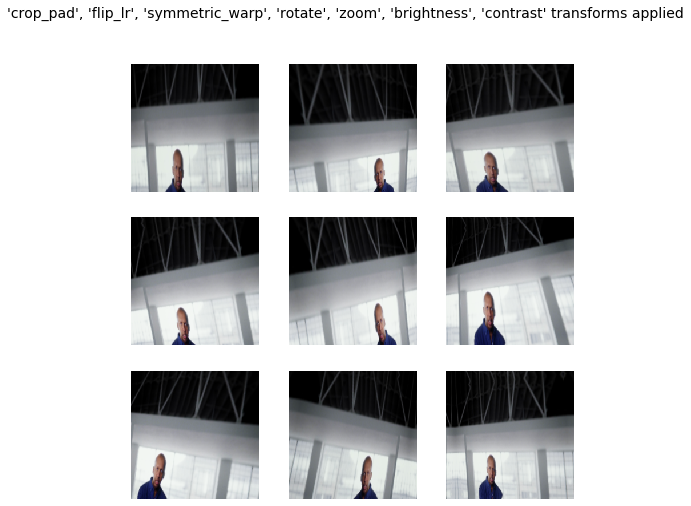

Learner(data=ImageDataBunch;

Train: LabelList (1565 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous
Path: .;

Valid: LabelList (250 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous,color_theory_analagous
Path: .;

Test: None, model=MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, k

In [20]:
Learner(data,arch()).show_tfms()

### Model

In [22]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics,#opt_func=opt_func, 
                    loss_func=loss_func)

## Training

### Flat cosine annealing w/ Ranger (Lookahead + RAdam) Optimiser

In [23]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics,#opt_func=opt_func, 
                    loss_func=loss_func)

In [25]:
model_name

'cat_color-theory_MNetV2-224x224_tfr-lrn'

In [26]:
learn.save(model_name) # avoid potential `SaveModelCallback` bugs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.92E-03


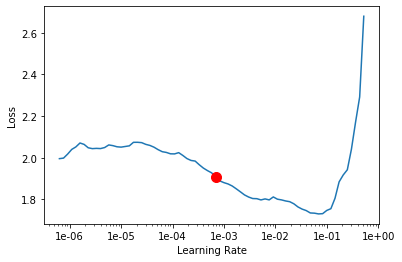

In [27]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [28]:
model_name = f'{model_name}-opt_adam-1cycle'
callbacks = get_callbacks(learn, model_name)

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with f_beta value: 0.4414791166782379.
Better model found at epoch 0 with f_beta value: 0.4414791166782379.
Better model found at epoch 1 with f_beta value: 0.5578392744064331.
Better model found at epoch 1 with f_beta value: 0.5578392744064331.
Better model found at epoch 2 with f_beta value: 0.6104168891906738.
Better model found at epoch 2 with f_beta value: 0.6104168891906738.
Better model found at epoch 3 with f_beta value: 0.6477606296539307.
Better model found at epoch 3 with f_beta value: 0.6477606296539307.
Better model found at epoch 4 with f_beta value: 0.6554656624794006.
Better model found at epoch 4 with f_beta value: 0.6554656624794006.
Better model found at epoch 5 with f_beta value: 0.6663735508918762.
Better model found at epoch 5 with f_beta value: 0.6663735508918762.
Better model found at epoch 6 with f_beta value: 0.6750143766403198.
Better model found at epoch 6 with f_beta value: 0.6750143766403198.
Better model found at epoch 7 with

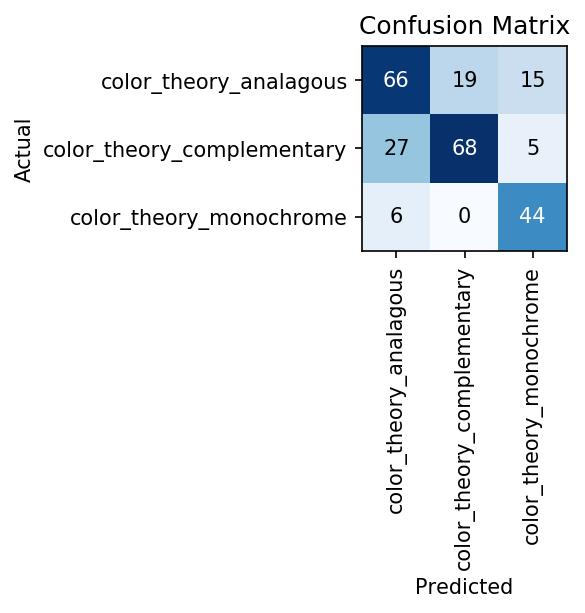

In [29]:
learn.fit_one_cycle(25, 1e-3, wd=1e-2, callbacks=callbacks)

## Interpretation

In [33]:
learn.load(model_name);

In [34]:
interpret = learn.interpret()

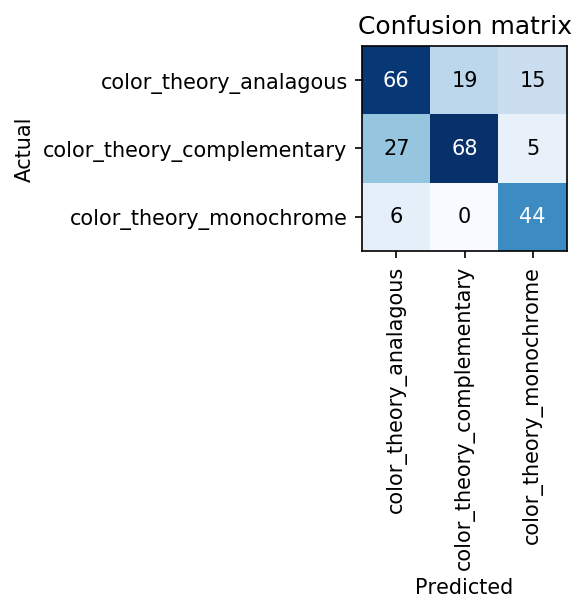

In [35]:
interpret.plot_confusion_matrix(dpi=150)

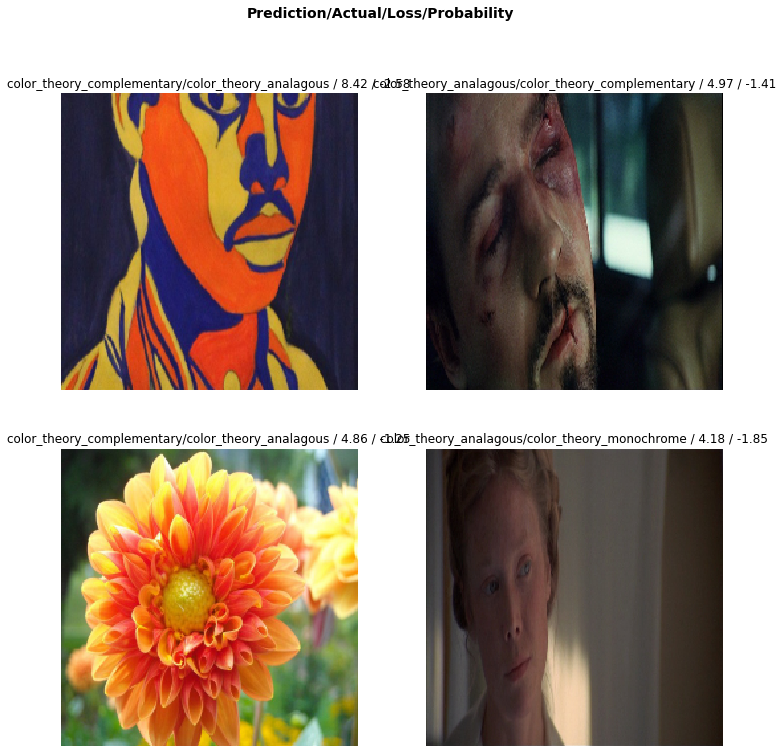

In [36]:
interpret.plot_top_losses(4)

In [37]:
interpret.most_confused()

[('color_theory_complementary', 'color_theory_analagous', 27),
 ('color_theory_analagous', 'color_theory_complementary', 19),
 ('color_theory_analagous', 'color_theory_monochrome', 15),
 ('color_theory_monochrome', 'color_theory_analagous', 6),
 ('color_theory_complementary', 'color_theory_monochrome', 5)]

It's clear that the labels that need more labelling are  `color_saturation_saturated` and `color_saturation_pastel`

## Rename Files & Save to Weights & Biases

In [39]:
learn.load(model_name); # this is just a sanity check, out callbacks would have loaded the best model anyways

In [40]:
torch_to_coreml(learn.model, data.c, model_fname=f'{model_name}-FULL')

Converted PyTorch to ONNX
Converting ONNX to CoreML

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Conver

In [41]:
!ls -l ../exported-models/{model_name}*

-rw-rw-r-- 1 rahul rahul 14340691 Feb 10 21:27 ../exported-models/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-FULL.mlmodel
-rw-rw-r-- 1 rahul rahul 14351161 Feb 10 21:27 ../exported-models/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-FULL.onnx


In [42]:
wandb.save(f'../exported-models/{model_name}*')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_150902-2x4dwlvt/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-FULL.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_150902-2x4dwlvt/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-FULL.mlmodel']

In [43]:
!ls {learn.path}/{model_name}*csv

/home/rahul/datasets/Synopsis_Model_All_Concepts/color_theory/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-history.csv


In [44]:
wandb.save(f'{learn.path}/{model_name}*csv')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_150902-2x4dwlvt/cat_color-theory_MNetV2-224x224_tfr-lrn-opt_adam-1cycle-history.csv']